In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from skimage.feature import hog
from scipy import ndimage

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA

In [2]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
 X, y, test_size=1/7.0, random_state=0)

In [4]:
# Loại bỏ các điểm ảnh ở biên (giá trị 0)
def crop(data):
    data = data.reshape(28,28)
    r = data[~np.all(data == 0, axis=1)] # loại bỏ hàng toàn 0
    idx = np.argwhere(np.all(r[..., :] == 0, axis=0)) # vị trí cột toàn 0
    c = np.delete(r, idx, axis=1) # loại bỏ cột toàn 0
    res = cv2.resize(c, dsize=(28, 28)) # Trả lại về size 28x28
    res = res.flatten() # Chuyển lại thành array 1 chiều như ban đầu
    return res

In [5]:
def cropData(data):
    return np.apply_along_axis(crop, 1, data)

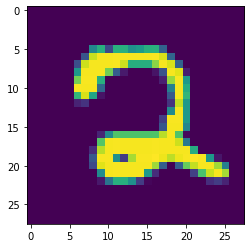

In [6]:
img = X_train[4].reshape(28,28,1)
plt.imshow(img);

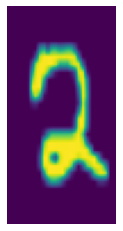

In [7]:
from skimage.transform import resize
resized_img = resize(img, (24*4, 12*4))
plt.axis("off")
plt.imshow(resized_img);

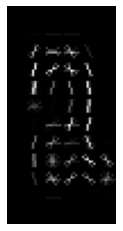

In [8]:
fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
plt.axis("off")
plt.imshow(hog_image, cmap="gray");

In [9]:
def Hog(data):
    img = data.reshape(28,28,1)
    resized_img = resize(img, (24*4, 12*4))
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True, multichannel=True)
    return fd

In [10]:
def HogData(data):
    return np.apply_along_axis(Hog, 1, data)

In [11]:
preprocess_pipeline = make_pipeline(FunctionTransformer(cropData),
                                    FunctionTransformer(HogData),
                                    StandardScaler())

In [12]:
start = time.time()
X_train_tf = preprocess_pipeline.fit_transform(X_train)
X_test_tf = preprocess_pipeline.fit_transform(X_test)
end = time.time()

print('Time to transform model: {}s'.format(end-start))

Time to transform model: 1661.155497789383s


In [13]:
start = time.time()
logreg_crop_model = LogisticRegression().fit(X_train_tf, y_train)
end = time.time()

print('Time to fit model: {}s'.format(end-start))

Time to fit model: 116.02949142456055s


/home/bao/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
# save the model to disk
import pickle
filename = 'hog_model.sav'
pickle.dump(logreg_crop_model, open(filename, 'wb'))

In [15]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

preds_train_crop = loaded_model.predict(X_train_tf)
preds_test_crop = loaded_model.predict(X_test_tf)

# Evaluation
print('Train Error: {} %'.format(np.mean(preds_train_crop != y_train)*100))
print('Test Error: {} %\n'.format(np.mean(preds_test_crop != y_test)*100))

Train Error: 0.0 %
Test Error: 2.32 %

